# 📊 Modelagem Falha de Máquina - Desafio Técnico

- Nome: Thiago Augusto Santos Lima

“Falhas inesperadas em equipamentos geram custos altos e paradas não planejadas.”


Manutenção Preditiva
- Avalia a condição do equipamento para prever quando a manutenção é necessária.
- Economia de custos em relação à manutenção preventiva: tarefas feitas somente quando justificadas.
- Uma interrupção por falha custa, em média, o dobro de uma interrupção preventiva.
- Permite prever a probabilidade de falha antes que ocorra.
- Possibilidade de calcular a economia gerada pelo modelo.


### Importação das Bibliotecas

In [372]:
# 📦 Importação de bibliotecas
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

### Importação dos dados

In [373]:
# 🔄 Configurações iniciais

# Leitura dos dados
df = pd.read_csv("datasets/full_devices.csv", encoding='latin1')
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


## Tratamento e Criação de Novas Features

- Janela de observação: Optou-se por avaliar por máquina e aprender apenas com dados até d-3.
- Variáveis Lag: criadas para alguns atributos (Atributo1 e Atributo6) com lags de d-1, d-2 e d-3.
- Tendência: variável de tendência construída para o Atributo6, porém descartada.
- Redução de redundância: Atributos 7 e 8 são iguais → um foi descartado.
- Variáveis únicas: Atributo 9 tinha um valor diferente para cada máquina. 



In [374]:

# Colunas de atributos que queremos lagar
atributos = ['attribute1', 'attribute6']

# 1. Criar variáveis lag -1, -2, -3 por máquina, só para esses atributos
for lag in range(1, 4):  # de 1 a 3
    for attr in atributos:
        df[f'{attr}_lag_{lag}'] = df.groupby('device')[attr].shift(lag)

# 2. Criar variáveis target para t+1(falha nos próximos dias)
for horizon in [1]:
    df[f'failure_t_plus_{horizon}'] = df.groupby('device')['failure'].shift(-horizon)

# 3. Remover linhas com valores NA criados pelos shifts (opcional, ou pode usar depois para treinar)
df_clean = df.dropna().reset_index(drop=True)

print('Dimensão original:', df.shape)
print('Dimensão após criação das variáveis e remoção NA:', df_clean.shape)

# Mostrar as primeiras linhas para verificar
df_clean.head()




Dimensão original: (124494, 19)
Dimensão após criação das variáveis e remoção NA: (119822, 19)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute1_lag_1,attribute6_lag_1,attribute1_lag_2,attribute6_lag_2,attribute1_lag_3,attribute6_lag_3,failure_t_plus_1
0,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,124017368.0,407438.0,1650864.0,407438.0,215630672.0,407438.0,0.0
1,2015-01-04,S1F0166B,0,82195688,0,3,0,6,403175,0,0,0,77681360.0,403174.0,191946112.0,403174.0,61370680.0,403174.0,0.0
2,2015-01-04,S1F01E6Y,0,236917296,0,0,0,12,241264,0,0,0,214317232.0,240021.0,192723440.0,238718.0,173295968.0,237394.0,0.0
3,2015-01-04,S1F01JE0,0,235473648,0,0,0,6,410188,0,0,0,235562856.0,410186.0,109398680.0,410186.0,79694024.0,410186.0,0.0
4,2015-01-04,S1F01R2B,0,127529600,0,0,0,15,314088,0,0,3,196415520.0,313173.0,200864456.0,313173.0,135970480.0,313173.0,0.0


### Visão geral das variáveis contínuas:

In [375]:
#Visão geral das variáveis explicativas
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,attribute1_lag_1,attribute6_lag_1,attribute1_lag_2,attribute6_lag_2,attribute1_lag_3,attribute6_lag_3,failure_t_plus_1
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,1.233250e+05,123325.000000,1.221570e+05,122157.000000,1.209890e+05,120989.000000,123325.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524,1.223903e+08,260079.892836,1.224133e+08,259989.965201,1.223953e+08,259902.638463,0.000860
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623,7.046016e+07,99093.665392,7.046948e+07,99039.243152,7.046717e+07,98984.734032,0.029305
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000e+00,8.000000,0.000000e+00,8.000000,0.000000e+00,8.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,6.129859e+07,221462.000000,6.129819e+07,221469.000000,6.128346e+07,221481.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000,1.227989e+08,249721.000000,1.228196e+08,249602.000000,1.228013e+08,249511.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000,1.833145e+08,310207.000000,1.833727e+08,310055.000000,1.833237e+08,309930.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000,2.441405e+08,689062.000000,2.441405e+08,689035.000000,2.441405e+08,688964.000000,1.000000


Como existem muitas máquinas que estão no ar a muito tempo, não será preciso avaliar todo um histórico onde a máquina não falha. Por isso, optou-se por ter um olhar da base por máquina, transformando o dado histórico em variáveis lagueadas.

Como somente o atributo1 e o atributo6 apresentaram diferença significante entre os lags, seguiremos com eles.

In [376]:
# Criar lags
for lag in [1, 2, 3]:
    for attr in atributos:
        df[f'{attr}_lag_{lag}'] = df.groupby('device')[attr].shift(lag)

# Criar target t+1
df['failure_t_plus_1'] = df.groupby('device')['failure'].shift(-1)

# Filtrar apenas linhas com todos os lags preenchidos
df_lags_ok = df.dropna(subset=[f'{attr}_lag_{lag}' for attr in atributos for lag in [1,2,3]] + ['failure_t_plus_1'])

# Pegar a última linha de cada máquina
df_final = df_lags_ok.groupby('device').tail(1).reset_index(drop=True)


In [377]:
# Remover atributo8 (redundante)
df = df.drop(columns=['attribute8'])

# Converter colunas de data
df['date'] = pd.to_datetime(df['date'])

Agora, utilizaremos o método Smote para geração de amostras sintéticas para a classe desbalanceada.

In [388]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# 1. Definir X e y

y = df_final['failure_t_plus_1']
X = df_final.drop(columns=['failure_t_plus_1', 'attribute9','device', 'date', 'failure'])  # ajustar colunas irrelevantes


# 2. Separar treino/teste

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


# 3. Normalizar apenas as colunas numéricas

num_cols = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


# 4. Aplicar SMOTE no treino

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



XGBoost treinado com sucesso


Com a amostra já balanceada, serão realizados os treinamento dos modelos. Ao invés de avaliar através de processos de cross-validation, vamos testar diretamente na base teste.

In [ ]:
# 5. Treinar modelos
# -----------------------------
# Logistic Regression
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train_res, y_train_res)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_res, y_train_res)

# XGBoost
# Treinar XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                          scale_pos_weight=(y_train_res == 0).sum() / (y_train_res == 1).sum())
xgb_model.fit(X_train_res, y_train_res)
print("XGBoost treinado com sucesso")


Como os modelos geram probabilidades, podemos utilizar a curva ROC e otimizar o ponto de corte ideal para o modelo. Com isso, foi contruído uma função que apresenta a curva roc e otimiza esse ponto de corte.

In [379]:
# 📌 Função auxiliar para avaliar modelos
def avaliar_modelo(modelo, X_train, X_test, y_train, y_test):
    y_pred_prob = modelo.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_prob)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    youden_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_index)]
    
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    
    print(f'🔹 Melhor ponto de corte: {best_threshold:.4f}')
    print(f'AUC: {auc:.4f}')
    print('Acurácia:', accuracy_score(y_test, y_pred))
    print('Precisão:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('\nMatriz de confusão:\n', confusion_matrix(y_test, y_pred))
    
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

Logo abaixo, encontra-se os resultados dos modelos aplicados nas amostras teste:

🔹 LogisticRegression
🔹 Melhor ponto de corte: 0.5110
AUC: 0.6893
Acurácia: 0.8314285714285714
Precisão: 0.2542372881355932
Recall: 0.5
F1: 0.33707865168539325

Matriz de confusão:
 [[276  44]
 [ 15  15]]


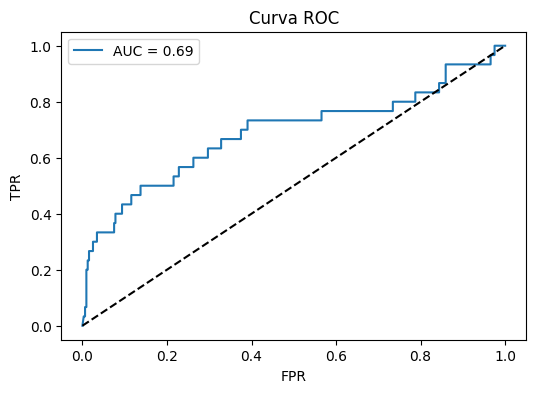

🔹 RandomForest
🔹 Melhor ponto de corte: 0.2800
AUC: 0.8436
Acurácia: 0.8571428571428571
Precisão: 0.34375
Recall: 0.7333333333333333
F1: 0.46808510638297873

Matriz de confusão:
 [[278  42]
 [  8  22]]


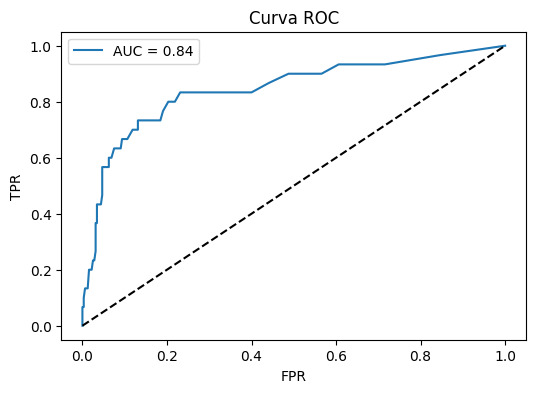

🔹 XGBoost
🔹 Melhor ponto de corte: 0.0451
AUC: 0.8092
Acurácia: 0.8285714285714286
Precisão: 0.2972972972972973
Recall: 0.7333333333333333
F1: 0.4230769230769231

Matriz de confusão:
 [[268  52]
 [  8  22]]


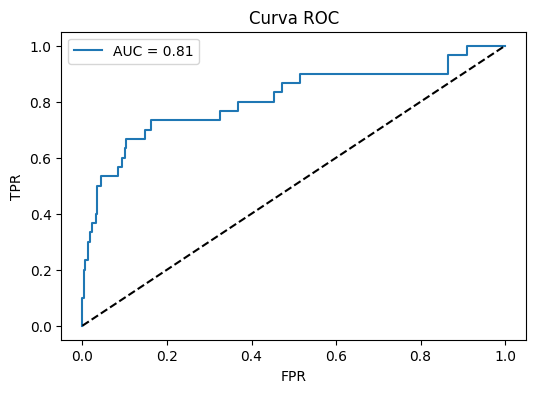

In [380]:
print("🔹 LogisticRegression")
avaliar_modelo(log_model, X_train_res, X_test, y_train_res, y_test)

print("🔹 RandomForest")
avaliar_modelo(rf_model, X_train_res, X_test, y_train_res, y_test)

print("🔹 XGBoost")
avaliar_modelo(xgb_model, X_train_res, X_test, y_train_res, y_test)


Após realizada a modelagem, é importante avaliar quais atributos foram essenciais na previsão das falhas.

In [386]:
import pandas as pd
import numpy as np

coef = log_model.coef_[0]
importance = pd.DataFrame({
    'feature': X_train_res.columns,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

print(importance)


             feature      coef  abs_coef
6         attribute7  1.101086  1.101086
7         attribute8  1.101086  1.101086
13  attribute6_lag_3 -0.328581  0.328581
0         attribute1  0.324027  0.324027
2         attribute3 -0.323709  0.323709
1         attribute2  0.303501  0.303501
3         attribute4  0.273217  0.273217
4         attribute5  0.271720  0.271720
9   attribute6_lag_1  0.199432  0.199432
10  attribute1_lag_2 -0.134893  0.134893
11  attribute6_lag_2 -0.023224  0.023224
5         attribute6 -0.012477  0.012477
8   attribute1_lag_1  0.007486  0.007486
12  attribute1_lag_3  0.004464  0.004464


In [382]:
importance = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance)


             feature  importance
1         attribute2    0.179901
3         attribute4    0.156146
7         attribute8    0.090038
6         attribute7    0.089539
4         attribute5    0.076275
11  attribute6_lag_2    0.057416
0         attribute1    0.054698
9   attribute6_lag_1    0.054083
13  attribute6_lag_3    0.053386
8   attribute1_lag_1    0.047283
5         attribute6    0.044546
12  attribute1_lag_3    0.042675
10  attribute1_lag_2    0.041753
2         attribute3    0.012261


In [383]:
importance = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance)


             feature  importance
3         attribute4    0.256796
1         attribute2    0.149511
6         attribute7    0.147979
2         attribute3    0.114186
9   attribute6_lag_1    0.075971
4         attribute5    0.047896
13  attribute6_lag_3    0.042372
11  attribute6_lag_2    0.041034
5         attribute6    0.032486
0         attribute1    0.028440
10  attribute1_lag_2    0.022871
8   attribute1_lag_1    0.021949
12  attribute1_lag_3    0.018510
7         attribute8    0.000000


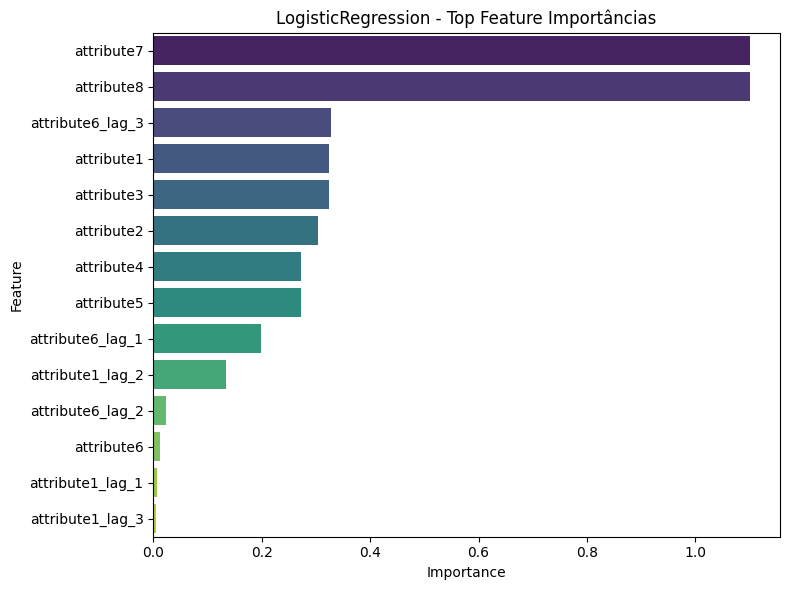

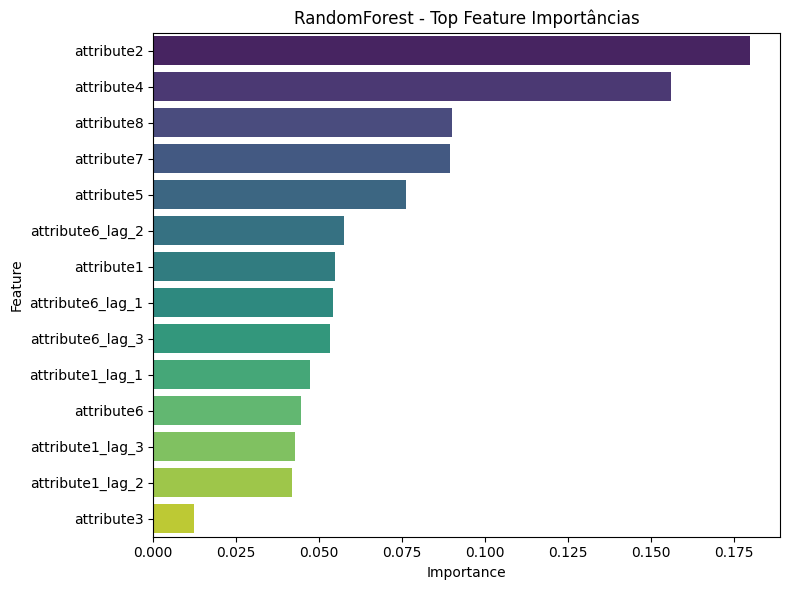

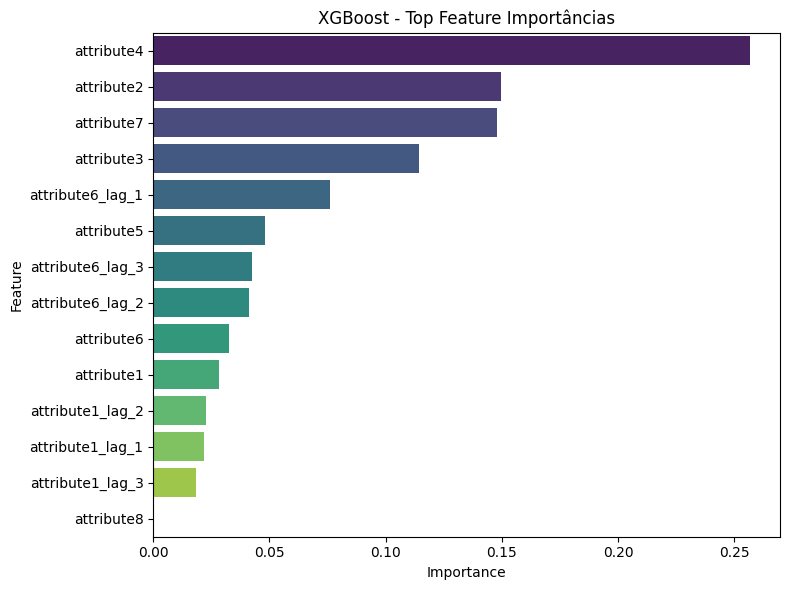

In [384]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, X_train, model_name, top_n=15):
    """
    Plota as top_n variáveis mais importantes de um modelo.
    Funciona para LogisticRegression, RandomForest e XGBoost.
    """
    if model_name == 'LogisticRegression':
        importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': np.abs(model.coef_[0])
        })
    else:  # RandomForest ou XGBoost
        importances = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        })
    
    importances = importances.sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=importances, palette='viridis')
    plt.title(f'{model_name} - Top Feature Importâncias')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_feature_importance(log_model, X_train_res, 'LogisticRegression')
plot_feature_importance(rf_model, X_train_res, 'RandomForest')
plot_feature_importance(xgb_model, X_train_res, 'XGBoost')


E para finalizar, serão calculados o custo total de manuntênção:

Regras de custo por máquina:
- Prevê falha & falha ocorre → economiza 50% do custo.
- Prevê falha & falha não ocorre → gasta 50% à toa.
- Não prevê falha & falha ocorre → gasta 100% do custo.
- Não prevê falha & falha não ocorre → não gasta nada.


In [385]:
def calcular_economia(modelo, X_test, y_test):
    # Previsão de probabilidade
    y_pred_prob = modelo.predict_proba(X_test)[:,1]
    
    # Determinar melhor ponto de corte (Youden index)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    best_threshold = thresholds[np.argmax(tpr - fpr)]
    
    # Previsão final
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    
    # Matriz de confusão
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Economia:
    # TP: +50%, FP: -50%, FN: -100%, TN: 0
    economia_total = tp*0.5 - fp*0.5 - fn*1
    
    print(f'🔹 Modelo: {modelo.__class__.__name__}')
    print(f'Ponto de corte ótimo: {best_threshold:.4f}')
    print(f'Matriz de confusão: TN={tn}, FP={fp}, FN={fn}, TP={tp}')
    print(f'Economia total (em unidades do custo base): {economia_total}\n')
    
    return economia_total

# Calcular para os 3 modelos
eco_log = calcular_economia(log_model, X_test, y_test)
eco_rf = calcular_economia(rf_model, X_test, y_test)
eco_xgb = calcular_economia(xgb_model, X_test, y_test)



🔹 Modelo: LogisticRegression
Ponto de corte ótimo: 0.5110
Matriz de confusão: TN=276, FP=44, FN=15, TP=15
Economia total (em unidades do custo base): -29.5

🔹 Modelo: RandomForestClassifier
Ponto de corte ótimo: 0.2800
Matriz de confusão: TN=278, FP=42, FN=8, TP=22
Economia total (em unidades do custo base): -18.0

🔹 Modelo: XGBClassifier
Ponto de corte ótimo: 0.0451
Matriz de confusão: TN=268, FP=52, FN=8, TP=22
Economia total (em unidades do custo base): -23.0



Dado que o custo esperado seja de 30, todos os modelos gerariam economia. Modelo de Florestas Aleatórias gerou a melhor economia.